# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [21]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [22]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.common import get_name_15min_chart, get_name_15min_chart_now

## yfinance による株価データの取得

In [23]:
code = "N225"
symbol = f"^{code}"
ticker = yf.Ticker(symbol)
df = ticker.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-07-16 09:00:00+09:00,39734.738281,39750.820312,39535.269531,39542.578125,0,0.0,0.0
2025-07-16 09:15:00+09:00,39544.621094,39586.910156,39520.960938,39541.078125,0,0.0,0.0
2025-07-16 09:30:00+09:00,39540.359375,39724.738281,39540.359375,39714.808594,0,0.0,0.0
2025-07-16 09:45:00+09:00,39712.980469,39748.679688,39702.941406,39747.808594,0,0.0,0.0
2025-07-16 10:00:00+09:00,39744.648438,39780.601562,39736.761719,39742.441406,0,0.0,0.0
2025-07-16 10:15:00+09:00,39741.988281,39749.628906,39704.710938,39705.531250,0,0.0,0.0
2025-07-16 10:30:00+09:00,39699.191406,39699.191406,39623.671875,39664.160156,0,0.0,0.0
2025-07-16 10:45:00+09:00,39662.929688,39695.789062,39642.539062,39664.039062,0,0.0,0.0
2025-07-16 11:00:00+09:00,39665.789062,39666.078125,39619.949219,39639.019531,0,0.0,0.0


## 前日終値の取得

In [24]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker.history(period="1d", interval="1d", start=str(dt_prev.date()))
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-07-15 00:00:00+09:00    39678.019531
Name: Close, dtype: float64

## ローソク足チャート（小さいサイズ）

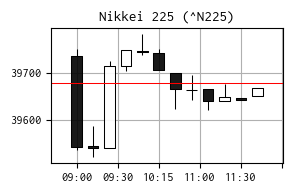

In [25]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 9

fig, ax = plt.subplots(figsize=(3, 2))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.set_ylabel(None)
ax.grid()

if "shortName" in ticker.info:
    ax.set_title(f"{ticker.info['shortName']} ({symbol})")
elif "longName" in ticker.info:
    ax.set_title(f"{ticker.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()